## DESIGN 6197/4197 | AI & Design: Generative AI from MLPs to APIs
## Homework 2 | Introduction to Convolutional Neural Networks (CNNs) and Generative Models | 15 Points Total

*Adapted from 4.453x Creative Machine Learning for Design @ MIT | Instructors: Renaud Danhaive, Ous Abou Ras, Natasha Hirt, and Caitlin Mueller*

This notebook is split into two parts. First, you will build a simple CNN for classifying digits. Then you will use convolutional layers in autoencoder (AE) and variational autoencoder (VAE) network architectures trained on the MNIST dataset. We use MNIST so we can focus on architecture considerations.


In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torchinfo import summary
from tqdm import tqdm
import scipy.stats


In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Your computations will be done on {device}")

Your computations will be done on cuda


### Part 1: Convolutional Neural Networks

In this section of the assignment you will re-implement [LeNet-5](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf).

![LeNet-5](imgs/lenet-5.png)

The goal of this network is to take in an image of a handwritten digit and predict the value of the digit. You performed a very similar task in HW1, but this time you will be defining a **convolutional neural network** or CNN to perform this classification task. 

#### Load data

The first thing you need to do is to download the MNIST datasets for testing and training. In this step you will also need to do some transformations to the dataset to prepare it for use in training your model. The images in the MNIST dataset are 28x28 pixels, however in LeNet5, they start with a slightly larger 32x32 pixel image input so you will need to resize this images. You also need to convert the image to a tensor. Then finally, you need to normalize the dataset. The mean of the pixel values in the training set is 0.1307 and standard deviation is 0.3081. 

To get the images up to the 32x32 pixel size you can use the [transforms.Resize()](https://pytorch.org/vision/stable/generated/torchvision.transforms.Resize.html) function, then you can use [transforms.ToTensor()](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html), and finally you can use [transforms.Normalize()](https://pytorch.org/vision/main/generated/torchvision.transforms.Normalize.html) with the given mean and standard deviation values to normalize the dataset. These transformations can be collected together using [transforms.Compose()](https://pytorch.org/vision/stable/generated/torchvision.transforms.Compose.html). (1 pt)

In [3]:
transform = transforms.Compose([transforms.Resize((32,32)), 
                                transforms.ToTensor(), 
                                transforms.Normalize(mean=(0.1307,), std=(0.3081,))]
)

mnist_training_set = torchvision.datasets.MNIST(
    "data", train=True, download=True, transform=transform
)
mnist_validation_set = torchvision.datasets.MNIST(
    "data", train=False, download=True, transform=transform
)

Next you will create the dataloader for the training set and the validation set. Make sure you set shuffle to `True`. (1 pt)

In [4]:
batch_size = 64

training_dataloader = torch.utils.data.DataLoader(
    mnist_training_set, shuffle=True, batch_size=batch_size
)
validation_dataloader = torch.utils.data.DataLoader(
    mnist_validation_set, shuffle=True, batch_size=batch_size
)

Now you will define the architecture of the LeNet5 model. In order to complete this section I will refer you to the paper on LeNet5 (https://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf) to determine the size of the kernels. On pages 7 and 8 of the PDF there is a description of the model architecture which refers to these kernels as 'neighborhoods' of the feature maps. The number of input and output channels for each piece of the network can be determined from the model architecture diagram at the top of the assignment (which comes from the linked paper). (3 pts)

In [5]:
class LeNet_5(torch.nn.Module):
    def __init__(self):
        super(LeNet_5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5, stride=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv3 = nn.Conv2d(16, 120, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(120, 84)
        self.fc2 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = F.tanh(x)      
        x = self.conv2(x)
        x = self.pool2(x)
        x = F.tanh(x)      
        x = self.conv3(x)
        x = F.tanh(x)
        x = x.view(-1, 120)
        x = self.fc1(x)
        x = F.tanh(x)
        x = self.fc2(x)

        return x

In [6]:
model = LeNet_5().to(device)

In [7]:
summary(model, input_size=(batch_size, 1, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet_5                                  [64, 10]                  --
├─Conv2d: 1-1                            [64, 6, 28, 28]           156
├─MaxPool2d: 1-2                         [64, 6, 14, 14]           --
├─Conv2d: 1-3                            [64, 16, 10, 10]          2,416
├─MaxPool2d: 1-4                         [64, 16, 5, 5]            --
├─Conv2d: 1-5                            [64, 120, 1, 1]           48,120
├─Linear: 1-6                            [64, 84]                  10,164
├─Linear: 1-7                            [64, 10]                  850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
Total mult-adds (M): 27.07
Input size (MB): 0.26
Forward/backward pass size (MB): 3.34
Params size (MB): 0.25
Estimated Total Size (MB): 3.85

In [8]:
#No need to write code here, just run this cell.
loss_fn = nn.CrossEntropyLoss() #This will automatically apply a softmax function to the model's output
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
n_epochs = 10

train_loss_history = []
train_accuracy_history = []

validation_loss_history = []
validation_accuracy_history = []

n_train_examples = len(training_dataloader)  # number of training batches
n_validation_examples = len(validation_dataloader)  # number of validation batches

for i in tqdm(range(n_epochs)):
    print(f"----- Epoch {i} -----")

    # --- VALIDATION ---
    validation_loss = 0
    validation_accuracy = 0

    for sample in validation_dataloader:
        image, target_class = sample

        # model predictions
        predictions = model(image.to(device))

        # compute loss
        validation_loss += (
            loss_fn(
                predictions,
                target_class.to(device),
            )
            / n_validation_examples
        )

        # compute accuracy
        class_predictions = torch.argmax(predictions, axis=1)
        validation_accuracy += (
            torch.count_nonzero(class_predictions == target_class.to(device))
            / batch_size
            / n_validation_examples
        )

    validation_loss_history.append(validation_loss.item())
    validation_accuracy_history.append(validation_accuracy.item())

    # --- TRAINING ---
    loss = 0
    accuracy = 0

    for sample in tqdm(training_dataloader):
        image, target_class = sample

        # model predictions
        predictions = model(image.to(device))

        batch_loss = loss_fn(
            predictions,
            target_class.to(device),
        )

        # backprop + gradient descent step
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()

        # compute loss
        loss += batch_loss / n_train_examples

        # compute accuracy
        class_predictions = torch.argmax(predictions, axis=1)
        accuracy += (
            torch.count_nonzero(class_predictions == target_class.to(device))
            / batch_size
            / n_train_examples
        )

    train_loss_history.append(loss.item())
    train_accuracy_history.append(accuracy.item())

    print(f"Training - Mean loss: {loss} | Accuracy: {int(accuracy*100)}%")
    print(f"Validation at epoch start - Mean loss: {validation_loss} | Accuracy: {int(validation_accuracy*100)}%")

  0%|          | 0/10 [00:00<?, ?it/s]

----- Epoch 0 -----


  0%|          | 0/10 [00:04<?, ?it/s]


KeyboardInterrupt: 

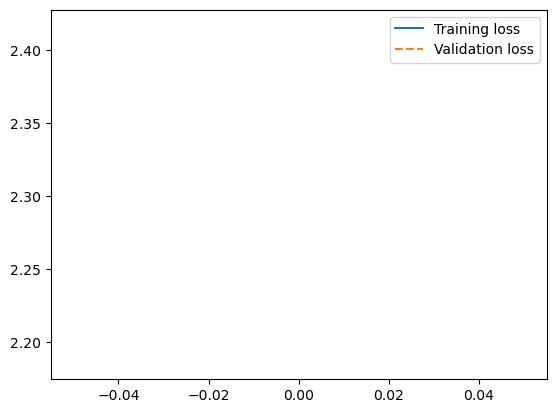

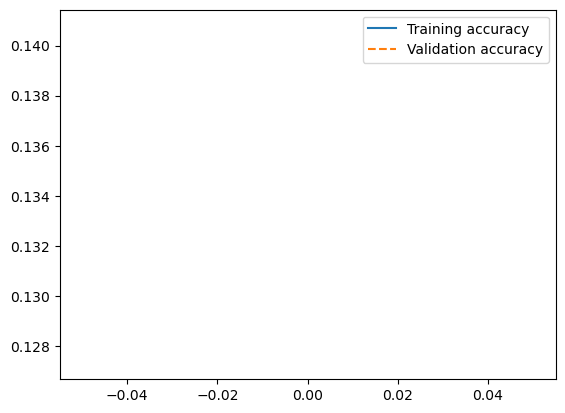

In [10]:
plt.plot(train_loss_history, label="Training loss")
plt.plot(validation_loss_history, linestyle="--", label="Validation loss")
plt.legend()
plt.show()
plt.plot(train_accuracy_history, label="Training accuracy")
plt.plot(validation_accuracy_history, linestyle="--", label="Validation accuracy")
plt.legend()
plt.show()

In [11]:
images, observations = next(iter(validation_dataloader))
predicted = torch.argmax(model(images.to(device)), axis=-1)

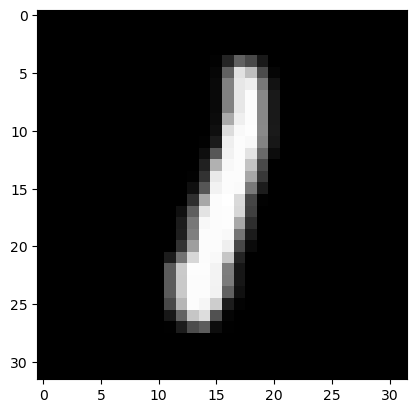

The actual digit is 1.
The predicted digit is 1.


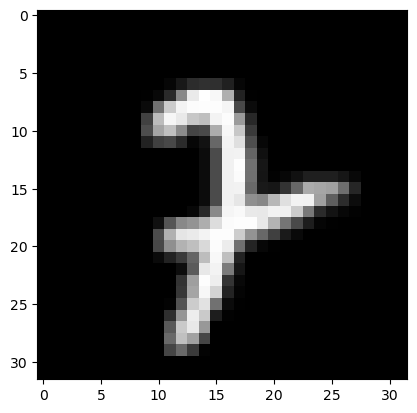

The actual digit is 7.
The predicted digit is 7.


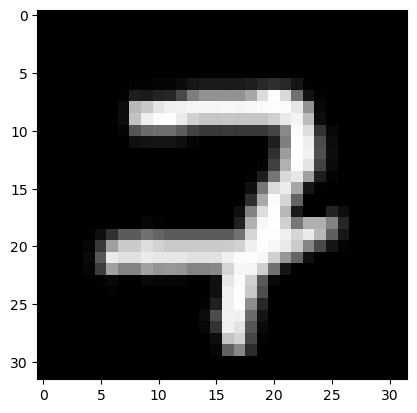

The actual digit is 7.
The predicted digit is 2.


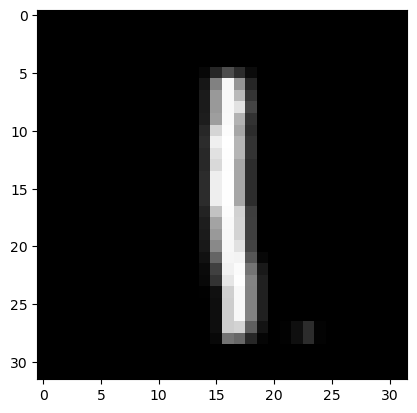

The actual digit is 1.
The predicted digit is 1.


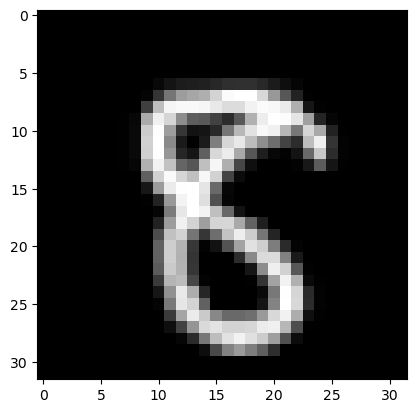

The actual digit is 8.
The predicted digit is 8.


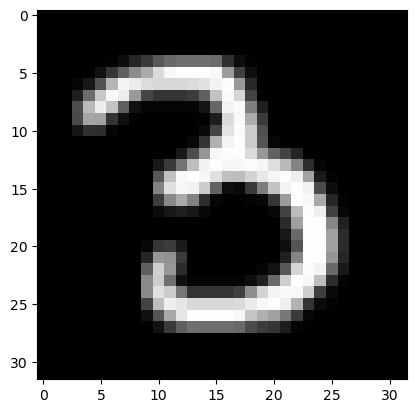

The actual digit is 3.
The predicted digit is 3.


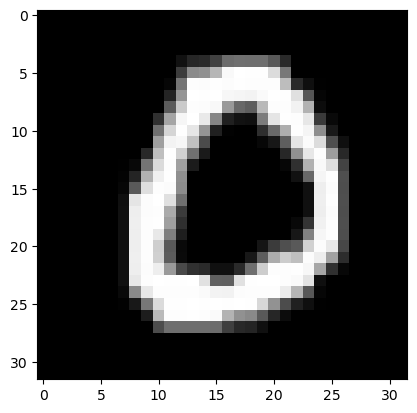

The actual digit is 0.
The predicted digit is 0.


In [12]:
for i, (img, digit, pred) in enumerate(zip(images, observations, predicted)):
    plt.imshow(img[0], cmap="gray")
    plt.grid(False)
    plt.show()
    print(f"The actual digit is {int(digit)}.")
    print(f"The predicted digit is {int(pred)}.")
    if i > 5:
        break

In [13]:
confusion_matrix = torch.zeros((10, 10))
digit_counts = torch.zeros(10)

for sample in validation_dataloader:
    image, target_class = sample

    # model predictions
    log_probabilities = model(image.to(device))

    # compute accuracy
    class_predictions = torch.argmax(log_probabilities, axis=1)

    for i, j in zip(target_class, class_predictions):
        confusion_matrix[i, j] += 1
        digit_counts[i] += 1  # count number of occurrences of each digit

confusion_matrix = confusion_matrix / digit_counts.reshape(-1, 1) * 100

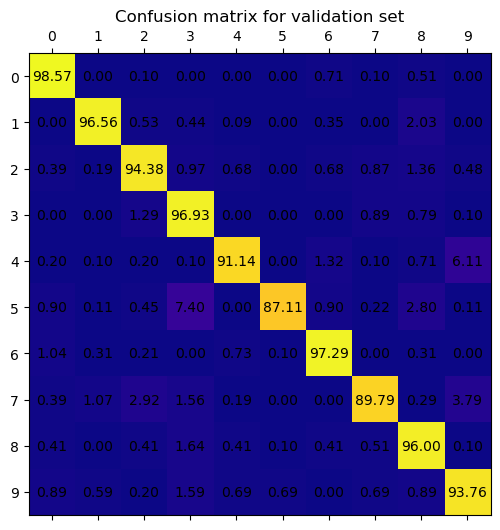

In [14]:
fig, ax = plt.subplots(figsize=(6, 6),)
plt.title("Confusion matrix for validation set")
# Using matshow here just because it sets the ticks up nicely. imshow is faster.
ax.matshow(confusion_matrix, cmap="plasma")

for (i, j), z in np.ndenumerate(confusion_matrix):
    ax.text(j, i, "{:0.2f}".format(z), ha="center", va="center")


ax.xaxis.set_ticks(range(10))
ax.yaxis.set_ticks(range(10))

plt.grid(False)
plt.show()

How does this compare to the confusion matrix you generated for your model in HW1? Answer in the markdown cell below. (1 pt)

In [15]:
del model, optimizer, loss_fn, training_dataloader, validation_dataloader, mnist_training_set, mnist_validation_set, transform

### Part 2 

In this section we will get back into building simple generative models. These models will allow you to do some interpolation in the latent space of the model in order to generate new samples.

#### Building an Autoencoder

Let's build an autoencoder module. We can build the overall structure of the autoencoder and simply assume it is fed the encoder and decoder modules as arguments.

In [24]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, encoder, decoder):
        super(AutoEncoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

An autoencoder is as simple as that! That said, we do need to define the encoders and decoders.

In [25]:
class Encoder(torch.nn.Module):
    def __init__(self, latent_dimensionality=2):
        super(Encoder, self).__init__()

        self.conv_1 = torch.nn.Conv2d(
            in_channels=1, out_channels=16, kernel_size=(3, 3), stride=(1, 1)
        )
        self.conv_2 = torch.nn.Conv2d(
            in_channels=16, out_channels=32, kernel_size=(3, 3), stride=(1, 1)
        )
        self.pool_1 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.conv_3 = torch.nn.Conv2d(
            in_channels=32, out_channels=64, kernel_size=(3, 3), stride=(1, 1)
        )
        self.pool_2 = torch.nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc_1 = torch.nn.Linear(in_features=64 * 5 * 5, out_features=32)
        self.fc_2 = torch.nn.Linear(in_features=32, out_features=latent_dimensionality)

    def forward(self, x):

        x = self.conv_1(x)  # 3x28x28 -> 16x26x26
        x = F.relu(x)
        x = self.conv_2(x)  # 16x26x26 -> 32x24x24
        x = F.relu(x)
        x = self.pool_1(x)  # 32x24x24 -> 32x12x12
        x = self.conv_3(x)  # 32x12x12 -> 64x10x10
        x = F.relu(x)
        x = self.pool_2(x)  # 64x10x10 -> 64x5x5
        x = x.view(x.shape[0], -1)  # flatten x
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)

        return x


# the decoder essentially mirrors the architecture of the encoder
class Decoder(torch.nn.Module):
    def __init__(self, latent_dimensionality=2):
        super(Decoder, self).__init__()

        self.fc_1 = torch.nn.Linear(in_features=latent_dimensionality, out_features=32)
        self.fc_2 = torch.nn.Linear(in_features=32, out_features=64 * 5 * 5)
        self.upsample_1 = torch.nn.UpsamplingNearest2d(scale_factor=(2, 2))
        self.conv_1 = torch.nn.Conv2d(
            in_channels=64,
            out_channels=32,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(2, 2),
        )
        self.upsample_2 = torch.nn.UpsamplingNearest2d(scale_factor=(2, 2))
        self.conv_2 = torch.nn.Conv2d(
            in_channels=32,
            out_channels=16,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(2, 2),
        )
        self.conv_3 = torch.nn.Conv2d(
            in_channels=16,
            out_channels=1,
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(2, 2),
        )

    def forward(self, x):
        x = self.fc_1(x)
        x = F.relu(x)
        x = self.fc_2(x)
        x = F.relu(x)
        x = x.view(-1, 64, 5, 5)
        x = self.upsample_1(x)
        x = self.conv_1(x)
        x = F.relu(x)
        x = self.upsample_2(x)
        x = self.conv_2(x)
        x = F.relu(x)
        x = self.conv_3(x)
        x = torch.sigmoid(x)  # squeeze pixel value between 0 and 1

        return x

In [26]:
ae_model = AutoEncoder(encoder=Encoder(), decoder=Decoder()).to(device)

In [27]:
summary(ae_model, input_size=(1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
AutoEncoder                              [1, 1, 28, 28]            --
├─Encoder: 1-1                           [1, 2]                    --
│    └─Conv2d: 2-1                       [1, 16, 26, 26]           160
│    └─Conv2d: 2-2                       [1, 32, 24, 24]           4,640
│    └─MaxPool2d: 2-3                    [1, 32, 12, 12]           --
│    └─Conv2d: 2-4                       [1, 64, 10, 10]           18,496
│    └─MaxPool2d: 2-5                    [1, 64, 5, 5]             --
│    └─Linear: 2-6                       [1, 32]                   51,232
│    └─Linear: 2-7                       [1, 2]                    66
├─Decoder: 1-2                           [1, 1, 28, 28]            --
│    └─Linear: 2-8                       [1, 32]                   96
│    └─Linear: 2-9                       [1, 1600]                 52,800
│    └─UpsamplingNearest2d: 2-10         [1, 64, 10, 10]           --

In [28]:
mnist_training_set = torchvision.datasets.MNIST(
    "data", train=True, download=True, transform=transforms.ToTensor()
)
mnist_validation_set = torchvision.datasets.MNIST(
    "data", train=False, download=True, transform=transforms.ToTensor()
)

batch_size = 64

training_dataloader = torch.utils.data.DataLoader(
    mnist_training_set, shuffle=True, batch_size=batch_size
)
validation_dataloader = torch.utils.data.DataLoader(
    mnist_validation_set, shuffle=True, batch_size=batch_size
)

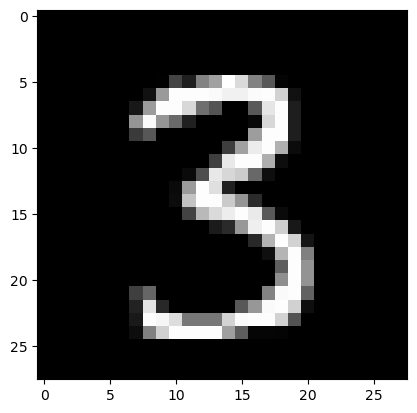

In [29]:
img = next(iter(training_dataloader))[0][0]
plt.imshow(img[0], cmap="gray")

In [30]:
optimizer = torch.optim.Adam(ae_model.parameters(), lr=0.001)
reconstruction_loss = nn.BCELoss()

In [31]:
n_epochs = 20

for i in tqdm(range(n_epochs)):

    # training
    training_losses = []
    for sample in training_dataloader:
        optimizer.zero_grad()

        img, _ = sample 
        img = img.to(device)
        #print(torch.min(img), torch.max(img))
        reconstructed = ae_model(img)
        loss = reconstruction_loss(reconstructed, img)
        #print(loss)

        loss.backward()
        optimizer.step()

        training_losses.append(loss.detach().cpu().numpy())

    # validation
    validation_losses = []
    for digit_images, _ in validation_dataloader:
        digit_images = digit_images.to(device)
        reconstructed = ae_model(digit_images)
        loss = reconstruction_loss(reconstructed, digit_images)

        validation_losses.append(loss.detach().cpu().numpy())

    print(
        "Epoch {0} | Mean training loss: {1:.3f} | Mean validation loss: {2:.3f}".format(
            i, np.mean(training_losses), np.mean(validation_losses)
        )
    )


  5%|▌         | 1/20 [00:08<02:47,  8.80s/it]

Epoch 0 | Mean training loss: 0.240 | Mean validation loss: 0.203


 10%|█         | 2/20 [00:17<02:39,  8.85s/it]

Epoch 1 | Mean training loss: 0.194 | Mean validation loss: 0.188


 15%|█▌        | 3/20 [00:26<02:30,  8.83s/it]

Epoch 2 | Mean training loss: 0.185 | Mean validation loss: 0.183


 20%|██        | 4/20 [00:34<02:16,  8.53s/it]

Epoch 3 | Mean training loss: 0.182 | Mean validation loss: 0.182


 25%|██▌       | 5/20 [00:43<02:09,  8.61s/it]

Epoch 4 | Mean training loss: 0.180 | Mean validation loss: 0.180


 30%|███       | 6/20 [00:51<01:57,  8.42s/it]

Epoch 5 | Mean training loss: 0.179 | Mean validation loss: 0.179


 35%|███▌      | 7/20 [00:59<01:47,  8.29s/it]

Epoch 6 | Mean training loss: 0.178 | Mean validation loss: 0.177


 40%|████      | 8/20 [01:08<01:41,  8.43s/it]

Epoch 7 | Mean training loss: 0.177 | Mean validation loss: 0.178


 45%|████▌     | 9/20 [01:16<01:33,  8.53s/it]

Epoch 8 | Mean training loss: 0.176 | Mean validation loss: 0.177


 50%|█████     | 10/20 [01:25<01:25,  8.59s/it]

Epoch 9 | Mean training loss: 0.176 | Mean validation loss: 0.177


 55%|█████▌    | 11/20 [01:34<01:17,  8.63s/it]

Epoch 10 | Mean training loss: 0.175 | Mean validation loss: 0.176


 60%|██████    | 12/20 [01:42<01:09,  8.63s/it]

Epoch 11 | Mean training loss: 0.174 | Mean validation loss: 0.176


 65%|██████▌   | 13/20 [01:51<01:00,  8.64s/it]

Epoch 12 | Mean training loss: 0.174 | Mean validation loss: 0.175


 70%|███████   | 14/20 [02:00<00:51,  8.64s/it]

Epoch 13 | Mean training loss: 0.174 | Mean validation loss: 0.175


 75%|███████▌  | 15/20 [02:08<00:43,  8.66s/it]

Epoch 14 | Mean training loss: 0.173 | Mean validation loss: 0.175


 80%|████████  | 16/20 [02:17<00:35,  8.77s/it]

Epoch 15 | Mean training loss: 0.173 | Mean validation loss: 0.174


 85%|████████▌ | 17/20 [02:26<00:26,  8.76s/it]

Epoch 16 | Mean training loss: 0.172 | Mean validation loss: 0.174


 90%|█████████ | 18/20 [02:34<00:17,  8.54s/it]

Epoch 17 | Mean training loss: 0.172 | Mean validation loss: 0.174


 95%|█████████▌| 19/20 [02:42<00:08,  8.39s/it]

Epoch 18 | Mean training loss: 0.172 | Mean validation loss: 0.174


100%|██████████| 20/20 [02:50<00:00,  8.54s/it]

Epoch 19 | Mean training loss: 0.171 | Mean validation loss: 0.173


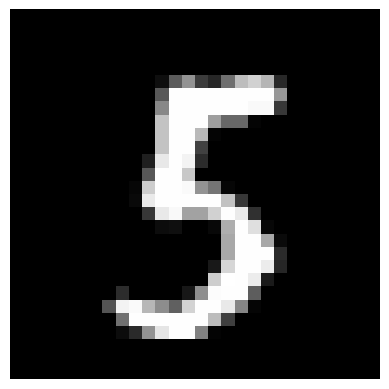

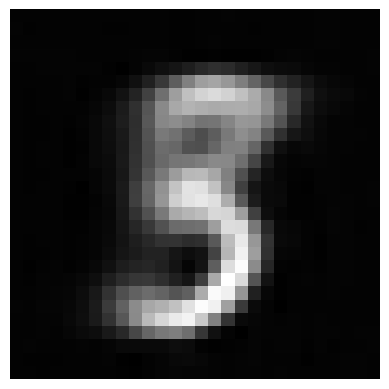

In [78]:
img_sample = next(iter(training_dataloader))[0].to(device)
i = 10
plt.imshow(img_sample.cpu()[i, 0], cmap="gray")
plt.axis("off")
plt.show()
plt.imshow(ae_model(img_sample).detach().cpu()[i, 0], cmap="gray")
plt.axis("off")
plt.show()

In [18]:
def get_all_encodings(model, dataloader):
    all_encoded = []
    all_labels = []
    for j, (digit_images, labels) in enumerate(dataloader):
        encoding = model.encoder(digit_images.to(device)).detach().cpu().numpy()
        all_encoded.append(encoding)
        all_labels.append(labels.numpy())

    all_encoded = np.concatenate(all_encoded)
    all_labels = np.concatenate(all_labels)
    return all_encoded, all_labels


def plot_mnist_encoding(model):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    # Training data
    ax[0].set_title(label="Encoding of MNIST training set")
    all_encoded, all_labels = get_all_encodings(model, training_dataloader)
    training_bbox = np.min(all_encoded, axis=0), np.max(all_encoded, axis=0)

    scatter = ax[0].scatter(
        all_encoded[:, 0],
        all_encoded[:, 1],
        c=all_labels,
        alpha=0.2,
        cmap="plasma",
        label="Training",
    )

    ax[0].legend(*scatter.legend_elements(), loc="lower left", title="Labels")

    # Validation data
    ax[1].set_title(label="Encoding of MNIST validation set")
    all_encoded, all_labels = get_all_encodings(model, validation_dataloader)
    validation_bbox = np.min(all_encoded, axis=0), np.max(all_encoded, axis=0)

    scatter = ax[1].scatter(
        all_encoded[:, 0],
        all_encoded[:, 1],
        c=all_labels,
        alpha=0.5,
        marker="+",
        cmap="plasma",
    )

    ax[1].legend(*scatter.legend_elements(), title="Labels", bbox_to_anchor=(1, 0.5))

    # adjust such that both subplots have same bounds
    ax[0].set_xlim(
        min(training_bbox[0][0], validation_bbox[0][0]),
        max(training_bbox[1][0], validation_bbox[1][0]),
    )
    ax[1].set_xlim(
        min(training_bbox[0][0], validation_bbox[0][0]),
        max(training_bbox[1][0], validation_bbox[1][0]),
    )

    ax[0].set_ylim(
        min(training_bbox[0][1], validation_bbox[0][1]),
        max(training_bbox[1][1], validation_bbox[1][1]),
    )
    ax[1].set_ylim(
        min(training_bbox[0][1], validation_bbox[0][1]),
        max(training_bbox[1][1], validation_bbox[1][1]),
    )

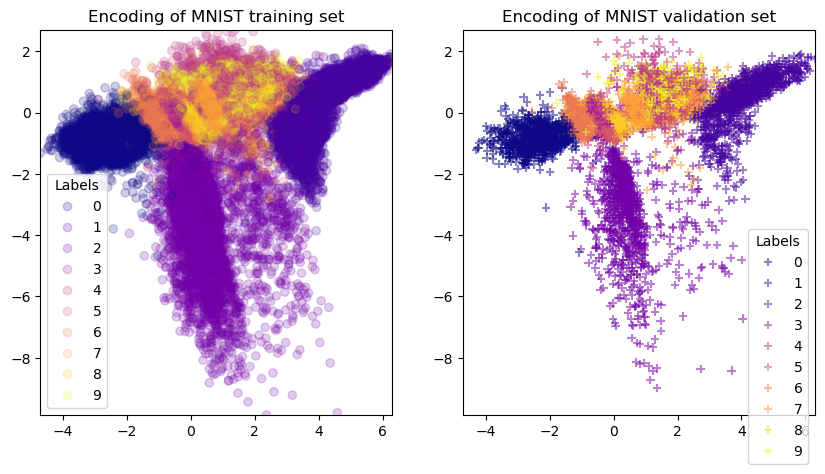

In [80]:
plot_mnist_encoding(ae_model)

The scatter plots of the encoded data above demonstrates that the encoder does a decent job at separating digits of different classes despite the extremely reduced dimensionality of the latent space. That said, the latent space is not necessarily meaningful. There are plenty of regions that are empty and the encoding does not follow a predictable structure making it difficult to use this latent space to generate samples.

To bring structure to the latent space, we need to enforce some sort of constraint over the structure of the latent space. This is where **Variational Autoencoders** (VAE) come in.

Let's save the model. All we have to do is save the so-called `state_dict` of the trained model, i.e. the model weights/parameters. We can then reload the model by simply loading it onto the model (as long as the model architecture is unchanged). This is the only thing we really need to save as long as we keep track of the architecture of the network we built. More details on saving models can be found in the [PyTorch documentation](https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_models_for_inference.html)

In [81]:
saved_file_name = "mnist_ae_weights.pth"  # the extension does not matter
# Save learned parameters
torch.save(ae_model.state_dict(), saved_file_name)

In [82]:
# Load model parameters
reloaded_ae_model = AutoEncoder(encoder=Encoder(), decoder=Decoder()).to(device)
reloaded_ae_model.load_state_dict(torch.load(saved_file_name))
reloaded_ae_model.eval()

C:\Users\Adam\AppData\Local\Temp\ipykernel_142040\634672283.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  reloaded_ae_model.load_state_dict(torch.load(saved_file_name)

AutoEncoder(
  (encoder): Encoder(
    (conv_1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (conv_2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (fc_1): Linear(in_features=1600, out_features=32, bias=True)
    (fc_2): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Decoder(
    (fc_1): Linear(in_features=2, out_features=32, bias=True)
    (fc_2): Linear(in_features=32, out_features=1600, bias=True)
    (upsample_1): UpsamplingNearest2d(scale_factor=(2.0, 2.0), mode='nearest')
    (conv_1): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (upsample_2): UpsamplingNearest2d(scale_factor=(2.0, 2.0), mode='nearest')
    (conv_2): Conv2d(32, 16, kernel_size=(3, 3), stride=(1

## 3. Variational autoencoder
We have built a vanilla autoencoder. As we've seen, its latent space does not look amazing. Let's see if how the latent space of an equivalent variational autoencoder looks!

In [12]:
class VariationalAutoEncoder(AutoEncoder):
    def __init__(self, encoder, decoder, latent_dimensionality):
        super(VariationalAutoEncoder, self).__init__(encoder, decoder)

        self.latent_dimensionality = latent_dimensionality

    def forward(self, x):
        x = self.encoder(x)
        mu = x[:, : self.latent_dimensionality]
        log_variance = x[:, self.latent_dimensionality :]
        # sample
        variance = torch.exp(log_variance)
        eps = torch.randn_like(variance)
        sample = mu + torch.sqrt(variance) * eps

        x = self.decoder(sample)
        return x, mu, log_variance



In [13]:
def kl_divergence(mu, log_variance):
    return 0.5 * torch.mean(mu ** 2 + torch.exp(log_variance) - (1 + log_variance))

reconstruction_loss = nn.BCELoss()

In [14]:
vae_model = VariationalAutoEncoder(
    Encoder(latent_dimensionality=4),
    Decoder(latent_dimensionality=2),
    latent_dimensionality=2,
).to(device)

In [15]:
optimizer = torch.optim.Adam(vae_model.parameters(), lr=0.001)

In [16]:
n_epochs = 20
reporting_frequency = 200
for i in tqdm(range(1, n_epochs + 1)):

    # training
    training_losses = []
    for j, (digit_images, _) in enumerate(training_dataloader):
        optimizer.zero_grad()
        digit_images = digit_images.to(device)
        reconstructed, mu, log_variance = vae_model(digit_images)
        reconstruction = reconstruction_loss(reconstructed, digit_images)
        kl_divergence_loss = kl_divergence(mu, log_variance)

        loss = reconstruction + 0.01 * kl_divergence_loss

        loss.backward()
        optimizer.step()

        training_losses.append(loss.detach().cpu().numpy())
        if (j + 1) % reporting_frequency == 0:
            print(
                "Epoch {0} | Mean training loss after {1} batches: {2:.3f}".format(
                    i, j + 1, np.mean(training_losses)
                )
            )

    # validation
    validation_losses = []
    for j, (digit_images, _) in enumerate(validation_dataloader):
        digit_images = digit_images.to(device)
        reconstructed, _, _ = vae_model(digit_images)
        loss = reconstruction_loss(reconstructed, digit_images)

        validation_losses.append(loss.detach().cpu().numpy())

    print(
        "Epoch {0} | Mean training total loss: {1:.3f} | Mean validation reconstruction loss: {2:.3f}".format(
            i, np.mean(training_losses), np.mean(validation_losses)
        )
    )

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1 | Mean training loss after 200 batches: 0.322
Epoch 1 | Mean training loss after 400 batches: 0.283
Epoch 1 | Mean training loss after 600 batches: 0.265
Epoch 1 | Mean training loss after 800 batches: 0.256


  5%|▌         | 1/20 [00:09<03:08,  9.95s/it]

Epoch 1 | Mean training total loss: 0.251 | Mean validation reconstruction loss: 0.209
Epoch 2 | Mean training loss after 200 batches: 0.225
Epoch 2 | Mean training loss after 400 batches: 0.224
Epoch 2 | Mean training loss after 600 batches: 0.223
Epoch 2 | Mean training loss after 800 batches: 0.223


 10%|█         | 2/20 [00:19<02:52,  9.59s/it]

Epoch 2 | Mean training total loss: 0.222 | Mean validation reconstruction loss: 0.202
Epoch 3 | Mean training loss after 200 batches: 0.220
Epoch 3 | Mean training loss after 400 batches: 0.220
Epoch 3 | Mean training loss after 600 batches: 0.219
Epoch 3 | Mean training loss after 800 batches: 0.219


 15%|█▌        | 3/20 [00:28<02:37,  9.25s/it]

Epoch 3 | Mean training total loss: 0.219 | Mean validation reconstruction loss: 0.199
Epoch 4 | Mean training loss after 200 batches: 0.218
Epoch 4 | Mean training loss after 400 batches: 0.217
Epoch 4 | Mean training loss after 600 batches: 0.217
Epoch 4 | Mean training loss after 800 batches: 0.217


 20%|██        | 4/20 [00:36<02:24,  9.02s/it]

Epoch 4 | Mean training total loss: 0.217 | Mean validation reconstruction loss: 0.198
Epoch 5 | Mean training loss after 200 batches: 0.215
Epoch 5 | Mean training loss after 400 batches: 0.216
Epoch 5 | Mean training loss after 600 batches: 0.216
Epoch 5 | Mean training loss after 800 batches: 0.216


 25%|██▌       | 5/20 [00:45<02:14,  8.99s/it]

Epoch 5 | Mean training total loss: 0.215 | Mean validation reconstruction loss: 0.195
Epoch 6 | Mean training loss after 200 batches: 0.214
Epoch 6 | Mean training loss after 400 batches: 0.215
Epoch 6 | Mean training loss after 600 batches: 0.214
Epoch 6 | Mean training loss after 800 batches: 0.214


 30%|███       | 6/20 [00:55<02:07,  9.09s/it]

Epoch 6 | Mean training total loss: 0.214 | Mean validation reconstruction loss: 0.194
Epoch 7 | Mean training loss after 200 batches: 0.213
Epoch 7 | Mean training loss after 400 batches: 0.213
Epoch 7 | Mean training loss after 600 batches: 0.213
Epoch 7 | Mean training loss after 800 batches: 0.213


 35%|███▌      | 7/20 [01:04<02:00,  9.25s/it]

Epoch 7 | Mean training total loss: 0.213 | Mean validation reconstruction loss: 0.192
Epoch 8 | Mean training loss after 200 batches: 0.214
Epoch 8 | Mean training loss after 400 batches: 0.213
Epoch 8 | Mean training loss after 600 batches: 0.212
Epoch 8 | Mean training loss after 800 batches: 0.212


 40%|████      | 8/20 [01:14<01:52,  9.35s/it]

Epoch 8 | Mean training total loss: 0.212 | Mean validation reconstruction loss: 0.191
Epoch 9 | Mean training loss after 200 batches: 0.212
Epoch 9 | Mean training loss after 400 batches: 0.212
Epoch 9 | Mean training loss after 600 batches: 0.212
Epoch 9 | Mean training loss after 800 batches: 0.212


 45%|████▌     | 9/20 [01:23<01:43,  9.40s/it]

Epoch 9 | Mean training total loss: 0.211 | Mean validation reconstruction loss: 0.191
Epoch 10 | Mean training loss after 200 batches: 0.211
Epoch 10 | Mean training loss after 400 batches: 0.211
Epoch 10 | Mean training loss after 600 batches: 0.211
Epoch 10 | Mean training loss after 800 batches: 0.211


 50%|█████     | 10/20 [01:33<01:35,  9.55s/it]

Epoch 10 | Mean training total loss: 0.211 | Mean validation reconstruction loss: 0.191
Epoch 11 | Mean training loss after 200 batches: 0.212
Epoch 11 | Mean training loss after 400 batches: 0.211
Epoch 11 | Mean training loss after 600 batches: 0.211
Epoch 11 | Mean training loss after 800 batches: 0.211


 55%|█████▌    | 11/20 [01:43<01:26,  9.58s/it]

Epoch 11 | Mean training total loss: 0.211 | Mean validation reconstruction loss: 0.190
Epoch 12 | Mean training loss after 200 batches: 0.211
Epoch 12 | Mean training loss after 400 batches: 0.210
Epoch 12 | Mean training loss after 600 batches: 0.210
Epoch 12 | Mean training loss after 800 batches: 0.210


 60%|██████    | 12/20 [01:52<01:17,  9.63s/it]

Epoch 12 | Mean training total loss: 0.210 | Mean validation reconstruction loss: 0.188
Epoch 13 | Mean training loss after 200 batches: 0.210
Epoch 13 | Mean training loss after 400 batches: 0.210
Epoch 13 | Mean training loss after 600 batches: 0.210
Epoch 13 | Mean training loss after 800 batches: 0.210


 65%|██████▌   | 13/20 [02:02<01:07,  9.65s/it]

Epoch 13 | Mean training total loss: 0.210 | Mean validation reconstruction loss: 0.188
Epoch 14 | Mean training loss after 200 batches: 0.210
Epoch 14 | Mean training loss after 400 batches: 0.210
Epoch 14 | Mean training loss after 600 batches: 0.210
Epoch 14 | Mean training loss after 800 batches: 0.209


 70%|███████   | 14/20 [02:12<00:58,  9.68s/it]

Epoch 14 | Mean training total loss: 0.210 | Mean validation reconstruction loss: 0.189
Epoch 15 | Mean training loss after 200 batches: 0.209
Epoch 15 | Mean training loss after 400 batches: 0.209
Epoch 15 | Mean training loss after 600 batches: 0.209
Epoch 15 | Mean training loss after 800 batches: 0.209


 75%|███████▌  | 15/20 [02:21<00:47,  9.57s/it]

Epoch 15 | Mean training total loss: 0.209 | Mean validation reconstruction loss: 0.187
Epoch 16 | Mean training loss after 200 batches: 0.209
Epoch 16 | Mean training loss after 400 batches: 0.209
Epoch 16 | Mean training loss after 600 batches: 0.209
Epoch 16 | Mean training loss after 800 batches: 0.209


 80%|████████  | 16/20 [02:30<00:37,  9.34s/it]

Epoch 16 | Mean training total loss: 0.209 | Mean validation reconstruction loss: 0.186
Epoch 17 | Mean training loss after 200 batches: 0.209
Epoch 17 | Mean training loss after 400 batches: 0.208
Epoch 17 | Mean training loss after 600 batches: 0.208
Epoch 17 | Mean training loss after 800 batches: 0.209


 85%|████████▌ | 17/20 [02:39<00:27,  9.19s/it]

Epoch 17 | Mean training total loss: 0.209 | Mean validation reconstruction loss: 0.188
Epoch 18 | Mean training loss after 200 batches: 0.208
Epoch 18 | Mean training loss after 400 batches: 0.208
Epoch 18 | Mean training loss after 600 batches: 0.208
Epoch 18 | Mean training loss after 800 batches: 0.208


 90%|█████████ | 18/20 [02:48<00:18,  9.10s/it]

Epoch 18 | Mean training total loss: 0.209 | Mean validation reconstruction loss: 0.187
Epoch 19 | Mean training loss after 200 batches: 0.208
Epoch 19 | Mean training loss after 400 batches: 0.209
Epoch 19 | Mean training loss after 600 batches: 0.208
Epoch 19 | Mean training loss after 800 batches: 0.208


 95%|█████████▌| 19/20 [02:58<00:09,  9.32s/it]

Epoch 19 | Mean training total loss: 0.208 | Mean validation reconstruction loss: 0.188
Epoch 20 | Mean training loss after 200 batches: 0.209
Epoch 20 | Mean training loss after 400 batches: 0.208
Epoch 20 | Mean training loss after 600 batches: 0.208
Epoch 20 | Mean training loss after 800 batches: 0.208


100%|██████████| 20/20 [03:07<00:00,  9.40s/it]

Epoch 20 | Mean training total loss: 0.208 | Mean validation reconstruction loss: 0.188


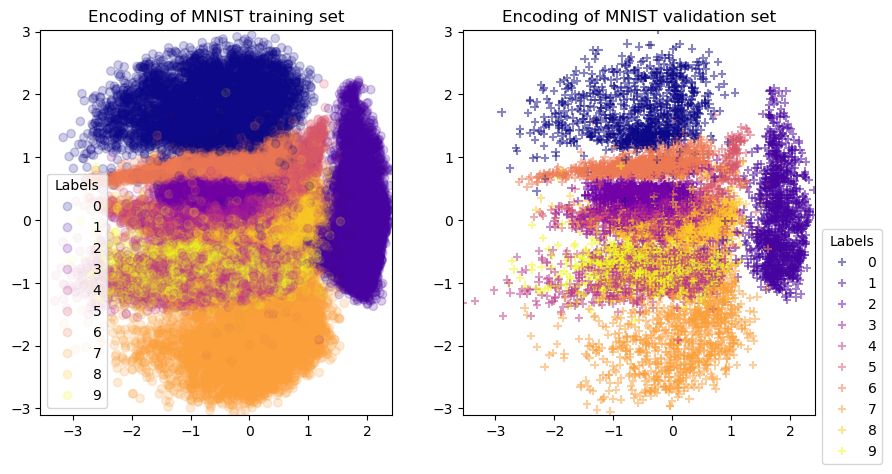

In [19]:
plot_mnist_encoding(vae_model)

The visualization above, especially in constrast to the identical one done for the regular autoencoder shows the impact of the Kullback-Leibler divergence on the distribution of the encoded points in the latent space.

Let's visualize how the entire latent space decodes at once. How can we do that? Well, we can simply sample the latent space with a grid at a given resolution, decode each point into an image using a decoder and plot the mosaic of decoded images to get a full picture of the latent space.

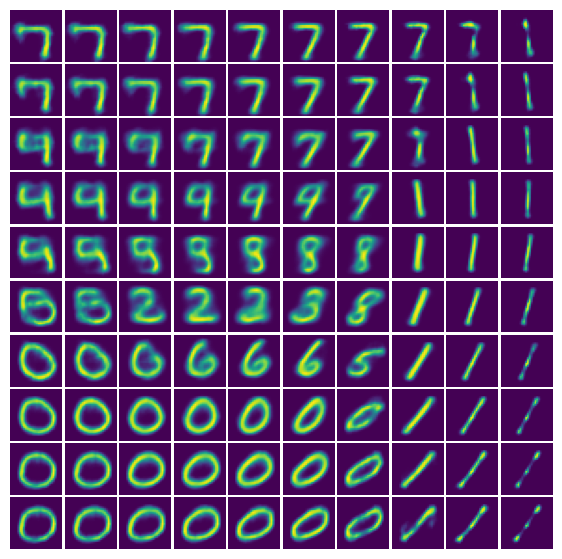

In [20]:
n = 10  # number of images per rows columns

# grid sampling in latent space
z = np.linspace(-3, 3, n)
Z1, Z2 = np.meshgrid(z, z)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

# decode samples
ims = vae_model.decoder(torch.tensor(Z).float().to(device).unsqueeze(0)).detach().cpu()

# plot
fig, axes = plt.subplots(n, n, figsize=(7, 7))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
count = 0
for k in range(0, ims.shape[0]):
    i, j = int(count / n), int(count % n)
    axes[i, j].imshow(ims[k, 0, :, :])
    axes[i, j].axis("off")
    count += 1
plt.show()

We sampled the latent space with a simple evenly-space grid. Is that how we should sample the latent space? Not quite. Indeed, with a VAE, we are trying to constrain our encoded data to fit a normal distribution. That is, we are forcing the encoding to be denser around $[0,0]$ and sparser further away from the origin. If we sample with an evenly-spaced grid, we are not sampling those denser regions as much as we should. The visualization above illustrates this as there is little variation in the decoded samples but at the very center of the mosaic. This is where we'd like to have a denser sampling

It turns out there is a simple solution to this issue: sample in probability space. Instead of sampling at $x$ where $[x=-3,x=-2,x=-1,...]$, we'll sample at $x$ where $[p(x)=0.05, p(x)=0.1, p(x)=0.15,...]$ where $p(x)$ is the cumulative density function (cdf) of the normal distribution (i.e. the probability that a sample from the normal distribution would be smaller than $x$). To find these sampling locations, we can use the inverse of the cdf, i.e. the percent point function (ppf) or quantile function, which is implemented in `scipy`.

This may seem a little esoteric, so let's plot things to shed some light on what this type of sampling translates to. The plot below shows the distribution of points sampled on an evenly-spaced grid and on a grid that is evenly-spaced in probability terms.

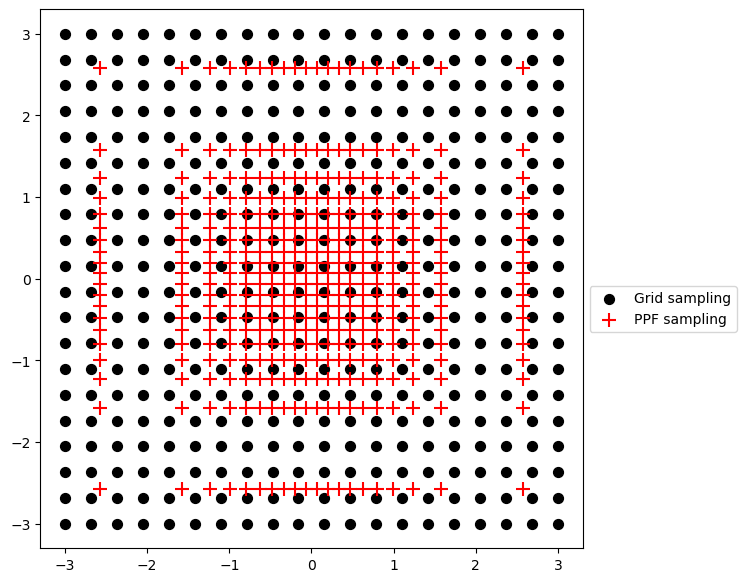

In [21]:
plt.figure(figsize=(7, 7))

n = 20  # sampling resolution
# evenly-spaced grid sampling in latent space
z = np.linspace(-3, 3, n)
Z1, Z2 = np.meshgrid(z, z)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

plt.scatter(Z[:, 0], Z[:, 1], s=50, c="black", label="Grid sampling")

z = scipy.stats.norm.ppf(np.linspace(0.005, 0.995, n))
Z1, Z2 = np.meshgrid(z, z)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

plt.scatter(Z[:, 0], Z[:, 1], marker="+", s=100, c="red", label="PPF sampling")
plt.legend(fontsize=10, bbox_to_anchor=(1, 0.5))
plt.show()

Now, let's use this sampling scheme on the MNIST VAE (with a higher resolution) and see what we get.

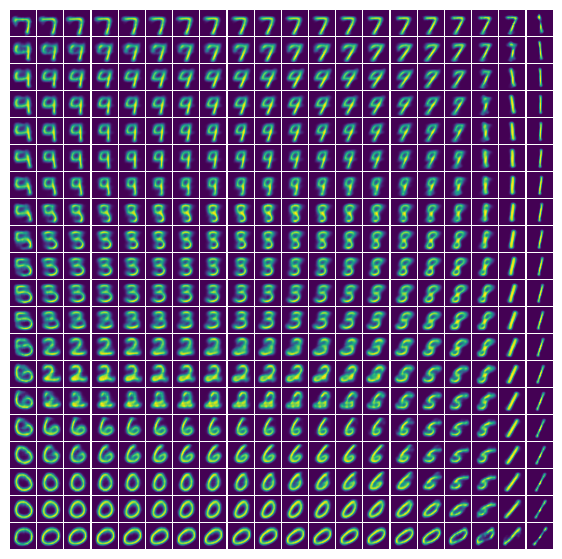

In [22]:
n = 20  # number of images per rows columns

# grid sampling in latent space
z = scipy.stats.norm.ppf(np.linspace(0.005, 0.995, n))
Z1, Z2 = np.meshgrid(z, z)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

# decode samples
ims = vae_model.decoder(torch.tensor(Z).float().to(device).unsqueeze(0)).detach().cpu()

# plot
fig, axes = plt.subplots(n, n, figsize=(7, 7))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
count = 0
for k in range(0, ims.shape[0]):
    i, j = int(count / n), int(count % n)
    axes[i, j].imshow(ims[k, 0, :, :])
    axes[i, j].axis("off")
    count += 1
plt.show()

We're now getting much more detail about what's happening closer to the origin, where most of the action truly is. This plot essentially provides a good snapshot of the spectrum of images the decoder is able to generate/reproduce.

What is pretty remarkable is the ability of the decoder to smoothly interpolate between different digits, for example to produce 1s that almost look like 9s or vice-versa.That is the power of latent variable modeling. And now, imagine those were pictures of designs. You could use the same technique to compress a design space and provide a reduced map of designs just like this. We'll discuss this type of approach this week.

Clearly, it cannot reproduce everything, as we would expect. Such heavy compression is almost inevitably lossy, and in this case, a latent dimensionality of 2 is probably too small. We may be able to push things further by increasing the complexity of the model but we would some limit because we just cannot fit an infinite amount of variation in that small space.

Reducing the size of your latent space almost inevitably means reducing its representational power, but a smaller latent space is also easier to explore, visualize, and exploit for design generation, so this trade-off is often worth it.

Let's build the same plot for the autoencoder to demonstrate the difference between the latent spaces produded. Since they encoding is not constrained to meet any sort of distribution, we'll use regular grid sampling across the bounding box of encoded validation samples.

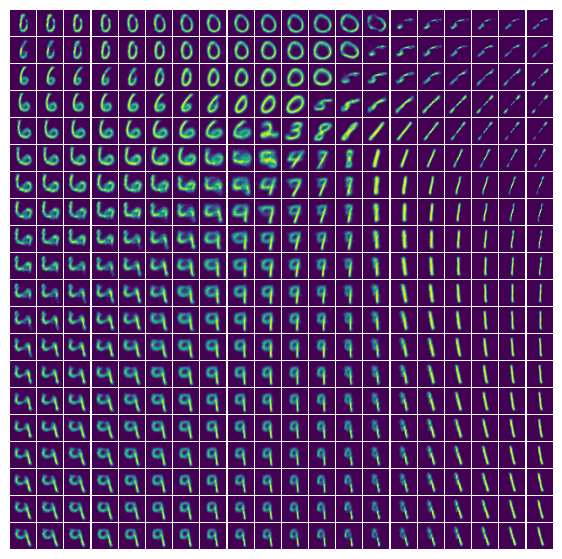

In [32]:
# get bounding box
ae_encodings, _ = get_all_encodings(ae_model, validation_dataloader)
x_min, y_min = np.min(ae_encodings, axis=0)
x_max, y_max = np.max(ae_encodings, axis=0)


n = 20  # number of images per rows columns

# grid sampling in latent space
z1 = np.linspace(0, 1, n) * (x_max - x_min) + x_min
z2 = np.linspace(0, 1, n) * (y_max - y_min) + y_min
Z1, Z2 = np.meshgrid(z1, z2)
Z = np.vstack([Z1.flatten(), Z2.flatten()]).T

# decode samples
ims = ae_model.decoder(torch.tensor(Z).float().to(device).unsqueeze(0)).detach().cpu()

# plot
fig, axes = plt.subplots(n, n, figsize=(7, 7))
fig.subplots_adjust(hspace=0.05, wspace=0.05)
count = 0
for k in range(0, ims.shape[0]):
    i, j = int(count / n), int(count % n)
    axes[i, j].imshow(ims[k, 0, :, :])
    axes[i, j].axis("off")
    count += 1
plt.show()

Clearly, the latent space is not as "nice" as the one produced by the VAE, i.e. most of the space contains little variations and/or garbage.

Congratulations, you have made it to the end of HW2! Please save you changes and then commit and sync them to github. Also, zip the folder for HW2 and upload it to Canvas.